# Look at correlations between ASC and cross slope heat transport across different spatial scales (e.g. single basins)

In [1]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import logging
import matplotlib.cm as cm


logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/x77/wf4500/ASC_project/analysis_figs/'

In [2]:
client = Client(memory_limit='1400gb',n_workers=48)

In [3]:
exp = '01deg_jra55v140_iaf_cycle3'
start_time= '1958-01-01'
end_time= '2018-12-31'
lat_range = slice(-90,-59)
isobath_depth = 1000

session = cc.database.create_session()

## First open u_along in density layers to use for compositing, and to show in time series:

In [4]:
# Load the along-slope velocity field
u_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/ASC_10deg_bin.nc')

# resample monthly:
u_along_da_months = u_along.resample(time='1M').mean()#.U_along_contour_binned
u_along_da_months = u_along_da_months.sel(potrho0=slice(13.8,28.42))#.rename({'lon_bin_midpoints': 'lon'})
u_along_da_months.load();

####################

# load monthly water mass mask:
age_mask = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/**_age_mask.nc')

# select out CDW layer:
u_along_da_months_binned_CDW = (age_mask.CDW_mask *u_along_da_months)

####################

# get volume for averaging across density layers:
vol_bins = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Volume_rho_10deg_bins.nc')

# do volume-weighted density average and annual averaging:
def vol_ave_potrho0_potmask(quantity,vol_bins):
    return (quantity * vol_bins.volume).mean('potrho0')/vol_bins.mean('potrho0').volume

U_along_annual_binned_CDW_volav = vol_ave_potrho0_potmask(u_along_da_months_binned_CDW,vol_bins).groupby('time.year').mean('time')
U_along_annual_binned_CDW_volav = U_along_annual_binned_CDW_volav.load()

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False


## Then open CSHT in density layers for time series:

In [5]:
# Load CSHT field
CSHT_along = xr.open_mfdataset('/g/data/hh5/tmp/access-om/fbd581/ASC_project/Lon_binning/CSHT_ZC_potrho0_10degBins.nc')

# resample monthly:
CSHT_along_monthly = CSHT_along.resample(time='1M').mean()

# apply age mask to select out CDW layer:
CSHT_months_binned_CDW = (age_mask.CDW_mask * CSHT_along_monthly )

# annual averaging and sum over layers:
CSHT_annual_binned_CDW = CSHT_months_binned_CDW.groupby('time.year').mean('time').sum(dim = 'potrho0')

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=blockwise
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False


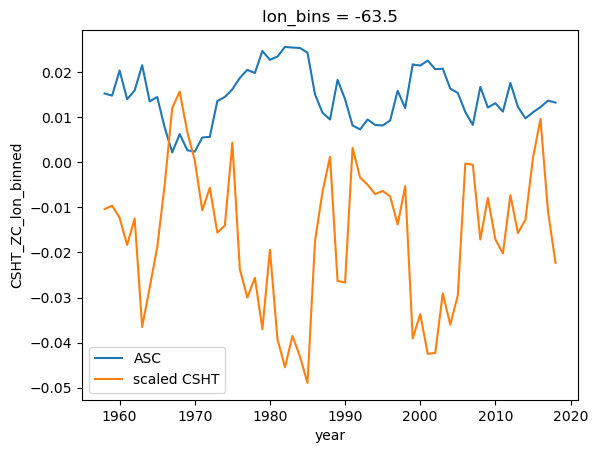

In [6]:
U_along_annual_binned_CDW_volav.U.sel(lon_bins=-63.5).plot(label='ASC')
(CSHT_annual_binned_CDW.CSHT_ZC_lon_binned.sel(lon_bins=-63.5)/2e14).plot(label='scaled CSHT')
plt.legend()

## Now open correlation data to check we're selecting the correct longitude bin:

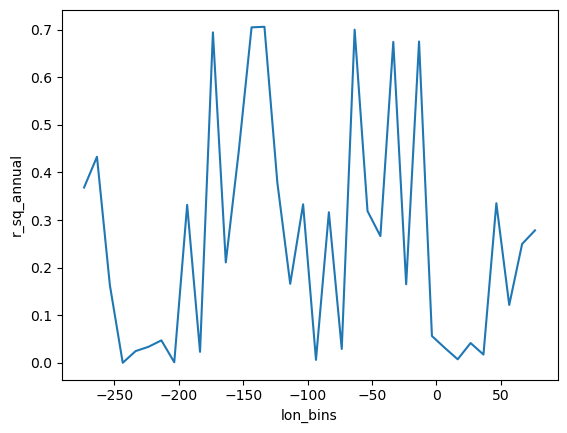

In [7]:
files_path = '/g/data/v45/qo9901/ASC_collab_CSHT_ds/'
file_extension = 'agemaskCDW_volav'

ds = xr.open_dataset(files_path + 'r_sq_annual_10degBins_' + file_extension + '.nc')
r_sq_annual_10deg = ds.r_sq_annual
ds.close()

r_sq_annual_10deg.plot()


In [8]:
r_sq_annual_10deg.where(r_sq_annual_10deg>0.3,drop=True).lon_bins

<xarray.DataArray 'lon_bins' (lon_bins: 15)> Size: 120B
array([-273.5, -263.5, -193.5, -173.5, -153.5, -143.5, -133.5, -123.5, -103.5,
        -83.5,  -63.5,  -53.5,  -33.5,  -13.5,   46.5])
Coordinates:
  * lon_bins  (lon_bins) float64 120B -273.5 -263.5 -193.5 ... -33.5 -13.5 46.5

In [9]:
r_sq_annual_10deg.sel(lon_bins=-63.5)

<xarray.DataArray 'r_sq_annual' ()> Size: 8B
array(0.699694)
Coordinates:
    lon_bins  float64 8B -63.5

In [10]:
# First look at tip of West Antarctic peninsula:

lon = -63.5



## Find years when bottom layer u_along is strongly westward (or less eastward):

In [36]:

Udata_notbinned = xr.open_dataset('/g/data/v45/wf4500/ASC_project_files/ASC_speed/daily_rho/WMbins_daily_rho/Antarctic_slope_contour_1km_velocities_1988-01-01_uv.nc')


In [21]:
#pick longitude bin:

# # tip of WAP:
# longitude = -63.5
# min_lat = -64.3
# u_levels = [-.12,-.08,-.04,.04,.08,.12,.16,.20,.24]
# vmin = -.2
# # for temp:
# norm = col.Normalize(vmin=-1.9,vmax=2.6)
# levels=np.arange(-1.9,2.6,.05)
# ticks = [-1,0,1,2]

# Getz east:
# longitude = -133.5
# min_lat = -74.6
# u_levels = [-.03,-.015,.015,.03]
# vmin=-.05
# # for temp:
# norm = col.Normalize(vmin=-1.8,vmax=1.5)
# levels=np.arange(-1.8,1.55,.05)
# ticks = [-1,0,1]


# Totten:
longitude = -243.5
min_lat = -74.6
u_levels = [-.03,-.015,.015,.03]
vmin=-.05
# for temp:
norm = col.Normalize(vmin=-1.8,vmax=1.5)
levels=np.arange(-1.8,1.55,.05)
ticks = [-1,0,1]

# # Getz west:
# longitude = -173.5
# min_lat = -75.5
# u_levels = [-.06,-.04,-.02,.02,.04,.06]
# vmin=-.05
# # for temp:
# norm = col.Normalize(vmin=-1.8,vmax=2)
# levels=np.arange(-1.8,2.05,.05)
# ticks = [-1,0,1,2]

# # Glomar:
# longitude = -173.5
# min_lat = -75.5
# u_levels = [-.06,-.04,-.02,.02,.04,.06]
# vmin=-.05
# # for temp:
# norm = col.Normalize(vmin=-1.8,vmax=2)
# levels=np.arange(-1.8,2.05,.05)
# ticks = [-1,0,1,2]

# # Amundsen:
# longitude = -103.5
# min_lat = -75.5
# u_levels = [-.06,-.04,-.02,.02,.04,.06]
# vmin=-.05
# # for temp:
# norm = col.Normalize(vmin=-1.8,vmax=2)
# levels=np.arange(-1.8,2.05,.05)
# ticks = [-1,0,1,2]

##########################

# select out longitude:
u_along_regional = U_along_annual_binned_CDW_volav.U.sel(lon_bins=longitude)

# find u_along threshold for most southward 100 months:
u_sorted = u_along_regional.sortby(u_along_regional)
npoints = 10
southward_threshold = u_sorted[npoints].data #negative, westward threshold for ASC
northward_threshold = u_sorted[-npoints].data #Positive, eastward threshold for ASC

# check we are selecting correct number (10) of years:
#u_along_regional.where(u_along_regional<southward_threshold)
#u_along_regional.where(u_along_regional>northward_threshold)

# import bathymetry:
hu_transect = cc.querying.getvar(exp,'hu',session,n=1)
hu_transect = hu_transect.sel(xu_ocean=longitude,method='nearest').sel(yu_ocean=lat_range)
# fill nans with zeros:
hu_transect = hu_transect.where(hu_transect>0,0)

# find latitude limits for plot:
lats = (hu_transect.yu_ocean).where(hu_transect>0).compute()
#min_lat = lats.dropna('yu_ocean').data[0]-.1
lats = (hu_transect.yu_ocean).where(hu_transect>2500).compute()
max_lat = lats.dropna('yu_ocean').data[0]

# NOTE!!!!
# This is currently just picking a single longitude. But we will want to average over the 10deg longitude bin.

# Use monthly data to pick southward times:
temp = cc.querying.getvar(exp, 'temp', session,frequency='1 monthly',start_time=start_time,end_time=end_time,chunks={'time': 12}
                        ).sel(time=slice(start_time,end_time)).sel(xt_ocean=longitude,method='nearest'
                        ).sel(st_ocean=slice(0,1300)).sel(yt_ocean=lat_range) - 273.15
temp = temp.groupby('time.year').mean().load()

temp_southward = temp.where(u_along_regional < southward_threshold).mean('year').load()
temp_northward = temp.where(u_along_regional > northward_threshold).mean('year').load()

rho = cc.querying.getvar(exp, 'pot_rho_0', session,frequency='1 monthly',start_time=start_time,end_time=end_time,chunks={'time': 12}
                        ).sel(time=slice(start_time,end_time)).sel(xt_ocean=longitude,method='nearest'
                        ).sel(st_ocean=slice(0,1300)).sel(yt_ocean=lat_range)
rho = rho.groupby('time.year').mean().load()

rho_southward = rho.where(u_along_regional < southward_threshold).mean('year').load()
rho_northward = rho.where(u_along_regional > northward_threshold).mean('year').load()

u = cc.querying.getvar(exp, 'u', session,frequency='1 monthly',start_time=start_time,end_time=end_time,chunks={'time': 12}
                        ).sel(time=slice(start_time,end_time)).sel(xu_ocean=longitude,method='nearest'
                        ).sel(st_ocean=slice(0,1300)).sel(yu_ocean=lat_range)
u = u.groupby('time.year').mean().load()

u_southward = u.where(u_along_regional < southward_threshold).mean('year').load()
u_northward = u.where(u_along_regional > northward_threshold).mean('year').load()

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:find_group_cohorts: cohorts is preferred, chunking is perfect.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=cohorts
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is False
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, retu

In [26]:
min_lat = -77

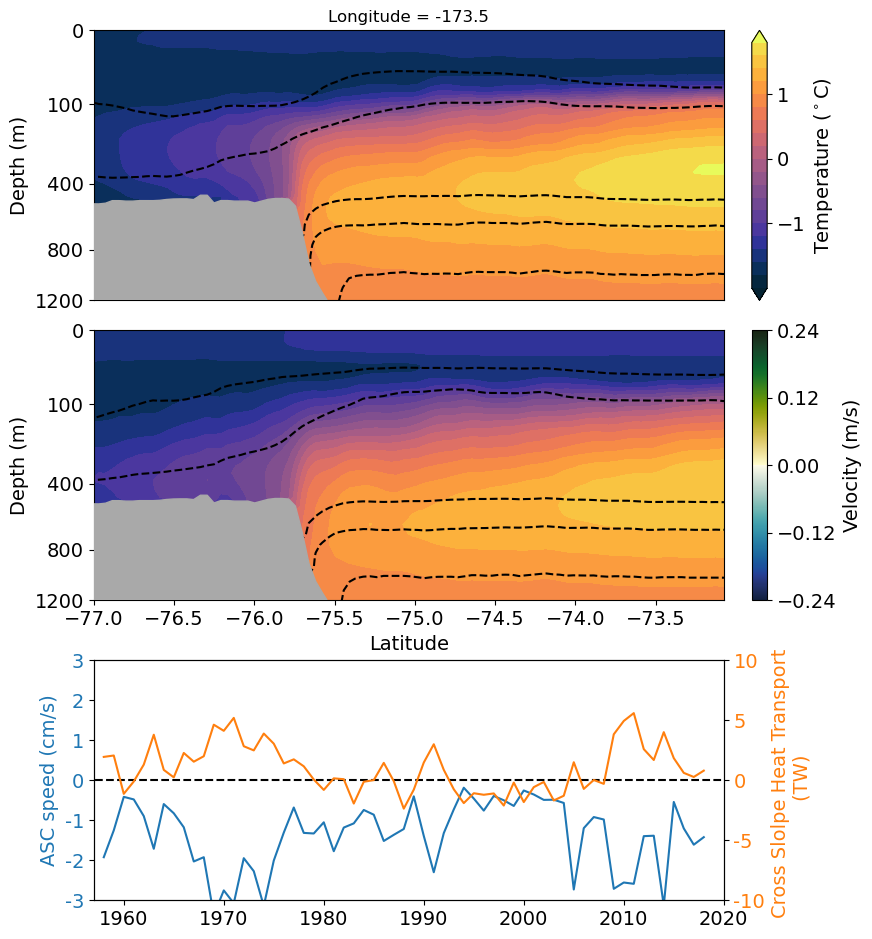

In [27]:
# Function x**(1/2)
def forward(x):
    return x**(1/2)


def inverse(x):
    return x**2
    
# plot single longitude:
# plot:
fontsize=14
density_contours = [1027.6,1027.7,1027.78,1027.8,1027.82,1027.83,1027.835]

fig=plt.figure(figsize=(7,6))
plt.clf()

# Northward CSHT:
ax1 = fig.add_axes([0.0,0.5,0.9,0.45])

norm = col.Normalize(vmin=-2,vmax=2)
levels=np.arange(-2,2,.2)
ticks = [-1,0,1]
'''norm = col.Normalize(vmin=-1.9,vmax=2.6)
levels=np.arange(-1.9,2.6,.05)
ticks = [-1,0,1,2]'''

pcm = ax1.contourf(temp_northward.yt_ocean,temp_northward.st_ocean,
                   temp_northward.interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate'),
                   cmap = cmocean.thermal, norm = norm,levels=levels,extend='both')
ax1.fill_between(temp_southward.yt_ocean,hu_transect,3000,zorder=3,color='darkgrey')
ax1.set_yscale('function', functions=(forward, inverse))
ax1.set_ylim(1200,0.5)
ax1.set_xlim(min_lat,max_lat+1)
ax1.set_ylabel('Depth (m)',fontsize=fontsize)
#ax1.set_xlabel('Longitude',fontsize=fontsize)
ax1.set_xticks([])
ax1.set_yticks([1200,800,400,100,0.5],labels=[1200,800,400,100,0])
plt.tick_params(labelsize=fontsize)
ax1.set_title('Longitude = '+str(longitude))

# colorbar:
cax = fig.add_axes([0.94,0.5,0.022,0.45])
cbar = plt.colorbar(pcm, cax=cax,orientation = 'vertical',extend = 'neither',ticks=ticks)
cbar.set_label(r'Temperature ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

cont=ax1.contour(rho_northward.yt_ocean,rho_northward.st_ocean,
                 rho_northward.interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate'),density_contours,
                  colors='k',zorder=2 ,fontsize=fontsize,linestyles='--')

#u_levels = [-.03,-.02,-.01,.01,.02,.03]
#u_levels = [-.03,-.015]
u_levels = [-.12,-.08,.08,.12,.16,.20,.24]
#u_levels = [-.08,-.06,-.04,-.02,.02,.04,.06,.08,.1,.12]

vmin=-u_levels[-1]
#vmin=-.05
#vmin=-.06
# before cmap was speed_r:
cont2=ax1.contour(u_northward.yu_ocean,u_northward.st_ocean,
                 u_northward.interpolate_na(dim='yu_ocean',method='nearest',fill_value='extrapolate'),u_levels,vmin=vmin,vmax=-vmin,
                  cmap=cmocean.delta,zorder=2 ,fontsize=fontsize)

cont2=ax1.pcolormesh(u_northward.yu_ocean,u_northward.st_ocean,
                 u_northward.interpolate_na(dim='yu_ocean',method='nearest',fill_value='extrapolate'),vmin=vmin,vmax=-vmin,
                  cmap=cmocean.delta,zorder=0 )
####################

ax2 = fig.add_axes([0.0,0.0,0.9,0.45])

pcm = ax2.contourf(temp_southward.yt_ocean,temp_southward.st_ocean,
                   temp_southward.interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate'),
                   cmap = cmocean.thermal, norm = norm,levels=levels,extend='both')
ax2.fill_between(temp_southward.yt_ocean,hu_transect,3000,zorder=3,color='darkgrey')
ax2.set_yscale('function', functions=(forward, inverse))
ax2.set_ylim(1200,0.5)
ax2.set_xlim(min_lat,max_lat+1)
ax2.set_ylabel('Depth (m)',fontsize=fontsize)
ax2.set_xlabel('Latitude',fontsize=fontsize)
#ax2.set_xticks([-74,-73.5,-73,-72.5])
#ax2.set_xticks([-66.5,-66,-65.5,-65])
ax2.set_yticks([1200,800,400,100,0.5],labels=[1200,800,400,100,0])
plt.tick_params(labelsize=fontsize)

#ax2.set_title('u_aong westward (or less northward)',fontsize=fontsize)

# colorbar:
cax = fig.add_axes([0.94,0.0,0.022,0.45])
cbar = plt.colorbar(cont2, cax=cax,orientation = 'vertical',extend = 'neither',ticks=[-.24,-.12,0,.12,.24])
cbar.set_label(r'Velocity (m/s)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)


cont=ax2.contour(rho_southward.yt_ocean,rho_southward.st_ocean,
                 rho_southward.interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate'),density_contours,
                  colors='k',zorder=2 ,fontsize=fontsize,linestyles='--')

cont2=ax2.contour(u_southward.yu_ocean,u_southward.st_ocean,
                 u_southward.interpolate_na(dim='yu_ocean',method='nearest',fill_value='extrapolate'),u_levels,vmin=vmin,vmax=-vmin,
                  cmap=cmocean.delta,zorder=2 ,fontsize=fontsize)


###################

ax3 = fig.add_axes([0.0,-0.5,0.9,0.4])
ax3_HT=ax3.twinx()
ax3.plot(U_along_annual_binned_CDW_volav.year,U_along_annual_binned_CDW_volav.U.sel(lon_bins=longitude)*100,label='ASC')
ax3.plot([1956,2024],[0,0],\
         linestyle='--',color='black')
ax3_HT.plot(U_along_annual_binned_CDW_volav.year,(CSHT_annual_binned_CDW.CSHT_ZC_lon_binned.sel(lon_bins=longitude)/1e12),\
            label='CSHT',color='tab:orange')
ax3.set_ylim(-3,3)
ax3.set_yticks([-3,-2,-1,0,1,2,3],labels=[-3,-2,-1,0,1,2,3],fontsize=14,color='tab:blue')
ax3.set_ylabel('ASC speed (cm/s)',fontsize=fontsize,color='tab:blue')
ax3_HT.set_ylim(-10,10)
ax3_HT.set_yticks([-10,-5,0,5,10],labels=[-10,-5,0,5,10],fontsize=14,color='tab:orange')
ax3_HT.set_ylabel('Cross Slolpe Heat Transport \n (TW)',fontsize=fontsize,color='tab:orange')

ax3.set_xticks(ticks=np.arange(1960,2021,10),labels=np.arange(1960,2021,10), fontsize=14)
ax3.set_xlim(1957,2020)
# save:
figure_path = figdir+'Transect'+str(longitude)+'.png'
plt.savefig(figure_path , dpi=300,bbox_inches='tight', pad_inches=0.1,facecolor='white')

(-280.0, 80.0)

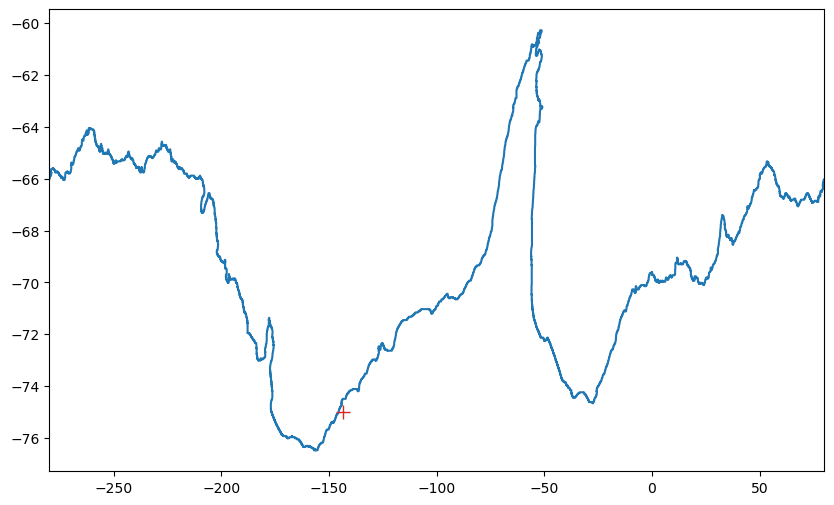

In [54]:
plt.figure(figsize=(10,6))
plt.plot(Udata_notbinned.lon_along_contour,Udata_notbinned.lat_along_contour)
plt.plot(-143.5,-75,color='tab:red',marker='+',markersize=10)
plt.xlim(-280,80)

In [52]:
r_sq_annual_10deg.sel(lon_bins=longitude)

<xarray.DataArray 'r_sq_annual' ()> Size: 8B
array(0.693991)
Coordinates:
    lon_bins  float64 8B -173.5

In [20]:
# plt.figure(figsize=(12,6))

# # for daily:
# CSHT_daily = ((CSHT_along.binned_cross_slope_heat_trans+CSHT_along.zonal_convergence)*0.08)
# CSHT_regional = CSHT_daily.sel(lon_bin_midpoints=longitude,method='nearest').sel(st_ocean=depth_range).sum('st_ocean').compute()
# plt.subplot(1,2,1)
# CSHT_regional.plot()
# times_southward = CSHT_regional.where(CSHT_regional<southward_threshold)
# times_southward.plot()
# times_northward = CSHT_regional.where(CSHT_regional>northward_threshold)
# times_northward.plot()
# plt.subplot(1,2,2)

# # Find threshold corresponding to 
# #southward_threshold = -1e11
# #northward_threshold = 3e11
# CSHT_regional_monthly.plot()
# times_southward_monthly = CSHT_regional_monthly.where(CSHT_regional_monthly<southward_threshold)
# times_southward_monthly.plot()
# times_northward_monthly = CSHT_regional_monthly.where(CSHT_regional_monthly>northward_threshold)
times_northward_monthly.plot()

AttributeError: 'Dataset' object has no attribute 'binned_cross_slope_heat_trans'

<Figure size 1200x600 with 0 Axes>

### Transect in East Antarctica of composite low/high CSHT times

In [ ]:
# use monthly data to compute time mean:
temp_mean = cc.querying.getvar(exp, 'temp', session,frequency='1 monthly',start_time=start_time,end_time=end_time,chunks={'time': 12}
                        ).sel(time=slice(start_time,end_time)).sel(xt_ocean=longitude,method='nearest'
                        ).sel(st_ocean=slice(0,3000)).sel(yt_ocean=lat_range).mean('time').compute()  - 273.15

rho_mean = cc.querying.getvar(exp, 'pot_rho_0', session,frequency='1 monthly',start_time=start_time,end_time=end_time,chunks={'time': 12}
                        ).sel(time=slice(start_time,end_time)).sel(xt_ocean=longitude,method='nearest'
                        ).sel(st_ocean=slice(0,3000)).sel(yt_ocean=lat_range).mean('time').compute()

# import bathymetry:
hu_transect = cc.querying.getvar(exp,'hu',session,n=1)
hu_transect = hu_transect.sel(xu_ocean=longitude,method='nearest').sel(yu_ocean=lat_range)
# fill nans with zeros:
hu_transect = hu_transect.where(hu_transect>0,0)
# find latitude limits for plot:
lats = (hu_transect.yu_ocean).where(hu_transect>0).compute()
min_lat = lats.dropna('yu_ocean').data[0]-.1
lats = (hu_transect.yu_ocean).where(hu_transect>3500).compute()
max_lat = lats.dropna('yu_ocean').data[0]

In [ ]:
# Try just using monthly data to pick southward times:

temp_southward = cc.querying.getvar(exp, 'temp', session,frequency='1 monthly',start_time=start_time,end_time=end_time,chunks={'time': 12}
                        ).sel(time=slice(start_time,end_time)).sel(xt_ocean=longitude,method='nearest'
                        ).sel(st_ocean=slice(0,1300)).sel(yt_ocean=lat_range) - 273.15

# Time coordinate on CSHT_regional_monthly is at end of month, not middle of month, 
# so first overwrite time on this variable so it matches time variable on temperature:
CSHT_regional_monthly['time'] = temp_southward.time

temp_southward = temp_southward.where(CSHT_regional_monthly<southward_threshold).mean('time').load()

rho_southward = cc.querying.getvar(exp, 'pot_rho_0', session,frequency='1 monthly',start_time=start_time,end_time=end_time,chunks={'time': 12}
                        ).sel(time=slice(start_time,end_time)).sel(xt_ocean=longitude,method='nearest'
                        ).sel(st_ocean=slice(0,1300)).sel(yt_ocean=lat_range)
rho_southward = rho_southward.where(CSHT_regional_monthly<southward_threshold).mean('time').load()

u_southward = cc.querying.getvar(exp, 'u', session,frequency='1 monthly',start_time=start_time,end_time=end_time,chunks={'time': 12}
                        ).sel(time=slice(start_time,end_time)).sel(xu_ocean=longitude,method='nearest'
                        ).sel(st_ocean=slice(0,1300)).sel(yu_ocean=lat_range)
u_southward = u_southward.where(CSHT_regional_monthly<southward_threshold).mean('time').load()

In [ ]:
# Try just using monthly data to pick northward times:

temp_northward = cc.querying.getvar(exp, 'temp', session,frequency='1 monthly',start_time=start_time,end_time=end_time,chunks={'time': 12}
                        ).sel(time=slice(start_time,end_time)).sel(xt_ocean=longitude,method='nearest'
                        ).sel(st_ocean=slice(0,1300)).sel(yt_ocean=lat_range) - 273.15

temp_northward = temp_northward.where(CSHT_regional_monthly>northward_threshold).mean('time').load()

rho_northward = cc.querying.getvar(exp, 'pot_rho_0', session,frequency='1 monthly',start_time=start_time,end_time=end_time,chunks={'time': 12}
                        ).sel(time=slice(start_time,end_time)).sel(xt_ocean=longitude,method='nearest'
                        ).sel(st_ocean=slice(0,1300)).sel(yt_ocean=lat_range)

rho_northward = rho_northward.where(CSHT_regional_monthly>northward_threshold).mean('time').load()

u_northward = cc.querying.getvar(exp, 'u', session,frequency='1 monthly',start_time=start_time,end_time=end_time,chunks={'time': 12}
                        ).sel(time=slice(start_time,end_time)).sel(xu_ocean=longitude,method='nearest'
                        ).sel(st_ocean=slice(0,1300)).sel(yu_ocean=lat_range)
u_northward = u_northward.where(CSHT_regional_monthly>northward_threshold).mean('time').load()

NameError: name 'temp_mean' is not defined

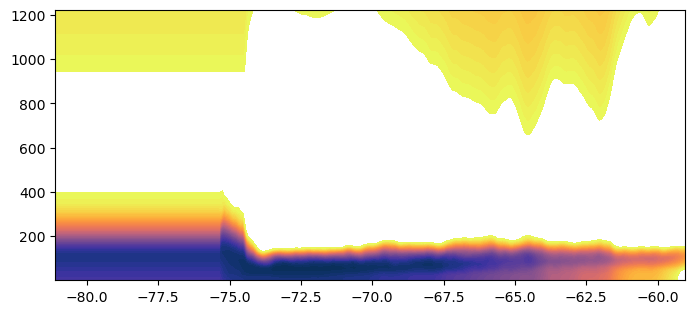

In [19]:
fontsize=14
density_contours = [1027.6,1027.7,1027.78,1027.8,1027.82,1027.83,1027.835]

fig=plt.figure(figsize=(7,6))

# Northward CSHT:
ax1 = fig.add_axes([0.0,0.5,0.9,0.45])

norm = col.Normalize(vmin=-2,vmax=1)
levels=np.arange(-2,1.05,.05)
ticks = [-2,-1,0,1]
'''norm = col.Normalize(vmin=-2,vmax=.5)
levels=np.arange(-2,.55,.05)
ticks = [-2,-1,0]'''

pcm = ax1.contourf(temp_northward.yt_ocean,temp_northward.st_ocean,
                   temp_northward.interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate'),
                   cmap = cmocean.thermal, norm = norm,levels=levels,extend='neither')
ax1.fill_between(temp_mean.yt_ocean,hu_transect,3000,zorder=3,color='darkgrey')
ax1.set_ylim(1200,0)
ax1.set_xlim(min_lat,max_lat)
ax1.set_ylabel('Depth (m)',fontsize=fontsize)
#ax1.set_xlabel('Longitude',fontsize=fontsize)
ax1.set_xticks([])
plt.tick_params(labelsize=fontsize)
ax1.set_title('CSHT northward, Longitude='+str(longitude),fontsize=fontsize)

# colorbar:
cax = fig.add_axes([0.94,0.5,0.022,0.45])
cbar = plt.colorbar(pcm, cax=cax,orientation = 'vertical',extend = 'neither',ticks=ticks)
cbar.set_label(r'Temperature ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

cont=ax1.contour(rho_northward.yt_ocean,rho_northward.st_ocean,
                 rho_northward.interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate'),density_contours,
                  colors='gray',zorder=2 ,fontsize=fontsize,linestyles='--')

cont2=ax1.contour(u_northward.yu_ocean,u_northward.st_ocean,
                 u_northward.interpolate_na(dim='yu_ocean',method='nearest',fill_value='extrapolate'),[-.1,-.05,.05,.1],
                  cmap=cmocean.amp,zorder=2 ,fontsize=fontsize)

ax2 = fig.add_axes([0.0,0.0,0.9,0.45])

pcm = ax2.contourf(temp_southward.yt_ocean,temp_southward.st_ocean,
                   temp_southward.interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate'),
                   cmap = cmocean.thermal, norm = norm,levels=levels,extend='neither')
ax2.fill_between(temp_southward.yt_ocean,hu_transect,3000,zorder=3,color='darkgrey')
ax2.set_ylim(1200,0)
ax2.set_xlim(min_lat,max_lat)
ax2.set_ylabel('Depth (m)',fontsize=fontsize)
ax2.set_xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
ax2.set_title('CSHT southward (or less northward)',fontsize=fontsize)

# colorbar:
cax = fig.add_axes([0.94,0.0,0.022,0.45])
cbar = plt.colorbar(pcm, cax=cax,orientation = 'vertical',extend = 'neither',ticks=ticks)
cbar.set_label(r'Temperature ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

cont=ax2.contour(rho_southward.yt_ocean,rho_southward.st_ocean,
                 rho_southward.interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate'),density_contours,
                  colors='k',zorder=2 ,fontsize=fontsize)
cont=ax2.contour(rho_northward.yt_ocean,rho_northward.st_ocean,
                 rho_northward.interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate'),density_contours,
                  colors='gray',zorder=2 ,fontsize=fontsize,linestyles='--')

cont2=ax2.contour(u_southward.yu_ocean,u_southward.st_ocean,
                 u_southward.interpolate_na(dim='yu_ocean',method='nearest',fill_value='extrapolate'),[-.1,-.05,.05,.1],
                  cmap=cmocean.amp,zorder=2 ,fontsize=fontsize)

In [23]:
# for daily data:
'''lat_range = slice(-67,-65)
temp_daily = cc.querying.getvar(exp, 'temp', session,frequency='1 daily',start_time=start_time,end_time=end_time,chunks={'time': 10}
                        ).sel(time=slice(start_time,end_time)).sel(xt_ocean=longitude,method='nearest'
                        ).sel(st_ocean=slice(0,1300)).sel(yt_ocean=lat_range) - 273.15

temp_southward = temp_daily.where(CSHT_regional<southward_threshold).mean('time').load()'''


2024-04-10 20:39:59,378 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:45303'.
2024-04-10 20:39:59,380 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:38515'.
2024-04-10 20:39:59,382 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:46761'.
2024-04-10 20:39:59,383 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:35205'.
2024-04-10 20:39:59,385 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:37867'.
2024-04-10 20:39:59,387 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:42261'.
2024-04-10 20:40:22,399 - distributed.nanny - ERROR - 
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/utils.py", line 832, in wrapper

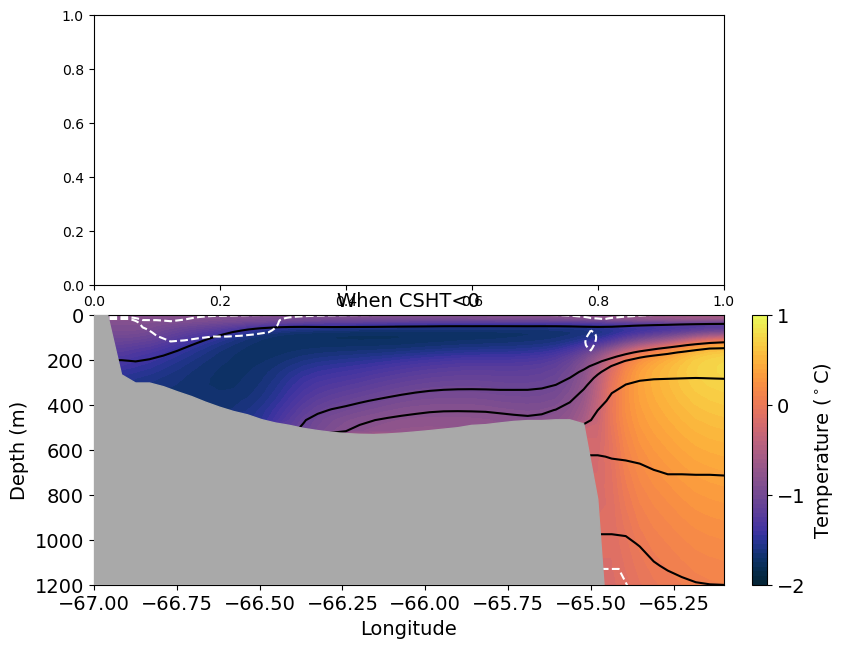

In [25]:
# for daily data:
fontsize=14
density_contours = [1027.6,1027.78,1027.8,1027.82,1027.83,1027.835]

fig=plt.figure(figsize=(7,6))

# Northward CSHT:
ax1 = fig.add_axes([0.0,0.5,0.9,0.45])

norm = col.Normalize(vmin=-2,vmax=1)
levels=np.arange(-2,1.05,.05)
ticks = [-2,-1,0,1]
'''norm = col.Normalize(vmin=-2,vmax=.5)
levels=np.arange(-2,.55,.05)
ticks = [-2,-1,0]'''

ax2 = fig.add_axes([0.0,0.0,0.9,0.45])

pcm = ax2.contourf(temp_southward.yt_ocean,temp_southward.st_ocean,
                   temp_southward.interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate'),
                   cmap = cmocean.thermal, norm = norm,levels=levels,extend='neither')
ax2.fill_between(temp_northward.yt_ocean,hu_transect,3000,zorder=3,color='darkgrey')
ax2.set_ylim(1200,0)
if longitude == -240:
    ax2.set_xlim(-67,-65.1)
elif longitude == -250:
    ax2.set_xlim(-66.7,-65)
elif longitude == -260:
    ax2.set_xlim(-65.8,-63.5)
ax2.set_ylabel('Depth (m)',fontsize=fontsize)
ax2.set_xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
ax2.set_title('When CSHT<0',fontsize=fontsize)

# colorbar:
cax = fig.add_axes([0.94,0.0,0.022,0.45])
cbar = plt.colorbar(pcm, cax=cax,orientation = 'vertical',extend = 'neither',ticks=ticks)
cbar.set_label(r'Temperature ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

cont=ax2.contour(rho_southward.yt_ocean,rho_southward.st_ocean,
                 rho_southward.interpolate_na(dim='yt_ocean',method='nearest',fill_value='extrapolate'),density_contours,
                  colors='k',zorder=2 ,fontsize=fontsize)

cont2=ax2.contour(u_southward.yu_ocean,u_southward.st_ocean,
                 u_southward.interpolate_na(dim='yu_ocean',method='nearest',fill_value='extrapolate'),[-.1,-.05,.05,.1],
                  colors='w',zorder=2 ,fontsize=fontsize)

### Check cross-slope heat transport in different layers

In [19]:
CSHT_monthly_mean = CSHT_monthly.mean('time')
CSHT_800_1200 = CSHT_monthly_mean.sel(st_ocean=slice(800,1200)).sum('st_ocean').compute()
CSHT_500_800 = CSHT_monthly_mean.sel(st_ocean=slice(500,800)).sum('st_ocean').compute()
CSHT_200_500 = CSHT_monthly_mean.sel(st_ocean=slice(200,500)).sum('st_ocean').compute()
CSHT_0_200 = CSHT_monthly_mean.sel(st_ocean=slice(0,200)).sum('st_ocean').compute()
CSHT_fulldepth = CSHT_monthly_mean.sum('st_ocean').compute()

In [16]:
(CSHT_monthly_mean.sum()/1e12).load()

<xarray.DataArray ()>
array(-17.48799009)

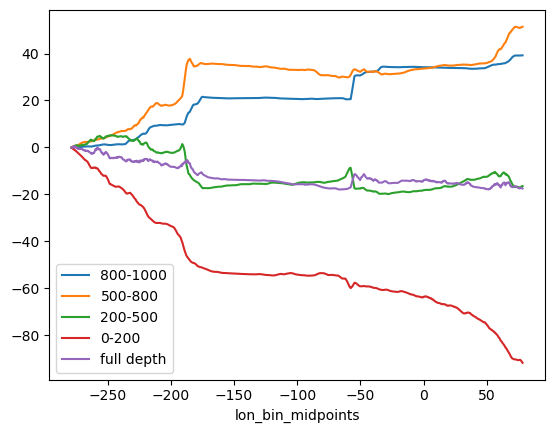

In [20]:
(CSHT_800_1200.cumsum()/1e12).plot(label='800-1000')
(CSHT_500_800.cumsum()/1e12).plot(label='500-800')
(CSHT_200_500.cumsum()/1e12).plot(label='200-500')
(CSHT_0_200.cumsum()/1e12).plot(label='0-200')
(CSHT_fulldepth.cumsum()/1e12).plot(label='full depth')
plt.legend()

In [8]:
# importing area for averaging
tarea = cc.querying.getvar(exp, 'area_t', session,n=1).sel(yt_ocean=lat_range)
dzt= cc.querying.getvar(exp, 'dzt', session,n=1,start_time=start_time,end_time=end_time).mean('time').sel(yt_ocean=lat_range)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


In [9]:
#coordinates for extraction of data along contour
lon_bin_midpoints = CSHT_along.isel(st_ocean=0,time=0).lon_bin_midpoints.drop(('time','st_ocean'))
lat_bin_midpoints = CSHT_along.isel(st_ocean=0,time=0).lat_bin_midpoints.drop(('time','st_ocean'))
lon_along_contour = CSHT_along.isel(st_ocean=0,time=0).lon_along_contour.drop(('time','st_ocean'))
lat_along_contour = CSHT_along.isel(st_ocean=0,time=0).lat_along_contour.drop(('time','st_ocean'))

# Extracting area along contour
tarea_ub = tarea.sel(yt_ocean=lat_along_contour,\
                     xt_ocean=lon_along_contour, method='nearest').compute()
tarea_b = tarea.sel(yt_ocean=lat_bin_midpoints,\
                    xt_ocean=lon_bin_midpoints, method='nearest').compute() 
# #the values on tarea_b are not realistic as the average of the unbined area in
# # the 3 degrees bin is likely no the area of the cel in the mid bin point.
# # But we are extracing anyways, to have an xarray with the coordinates we want. 
# # Below we actualy calculate the mean area, and will replace the resulting np.array
# #  in the xarray above.


dzt_ub=dzt.sel(yt_ocean=lat_along_contour,\
                     xt_ocean=lon_along_contour, method='nearest').compute()
dzt_b=dzt.sel(yt_ocean=lat_bin_midpoints,\
                     xt_ocean=lon_bin_midpoints, method='nearest').compute()
# #the values on dzt_b are not realistic as the average of the unbined area in
# # the 3 degrees bin is likely no the area of the cel in the mid bin point.
# # But we are extracing anyways, to have an xarray with the coordinates we want. 
# # Below we actualy calculate the mean area, and will replace the resulting np.array
# #  in the xarray above.
dzt_mean=dzt_ub.weighted(tarea_ub).mean('contour_index')

In [10]:
#binning the model area
# convert to longitude coordinate and average into 3 degree longitude bins:
# in degrees:
bin_width = 3
bin_spacing = 0.25
lon_west = -280
lon_east = 80

# new coordinate and midpoints of longitude bins:
full_lon_coord = np.arange(lon_west,lon_east+bin_spacing,bin_spacing)
lon_bin_midpoints0 = np.arange(lon_west+bin_width/2,lon_east-bin_width/2,bin_spacing)
n_bin_edges = len(full_lon_coord)
lon_along_contour0=np.array(lon_along_contour)
lat_along_contour0=np.array(lat_along_contour)
tarea_ub0=np.array(tarea_ub)
# sum into longitude bins:
# need to be very careful of loops, we can't just mask over longitude values, but instead pick indices 
# on the isobath contour and sum continously along contour between defined indices.
# (i.e. lon_along_contour is not monotonic)
# find points on contour to define edges of longitude bins:
bin_edge_indices = np.zeros(n_bin_edges)
for lon_bin in range(n_bin_edges-1):
	# find first isobath point that has the right longitude:
	first_point = np.where(lon_along_contour0>=full_lon_coord[lon_bin])[0][0]
	# then find all other isobath points with the same longitude as that first point:
	same_lon_points = np.where(lon_along_contour0==lon_along_contour0[first_point])[0]
	# we want the most southerly of these points on the same longitude line:
	bin_edge_indices[lon_bin] = same_lon_points[np.argmin(lat_along_contour0[same_lon_points])]
	
	# define east/west edges:
	bin_edge_indices = bin_edge_indices.astype(int)
	bin_edge_indices_west = bin_edge_indices[:-int(bin_width/bin_spacing)-1]
	bin_edge_indices_east = bin_edge_indices[int(bin_width/bin_spacing):-1]
	n_bins = len(bin_edge_indices_west)
	
	# sum heat transport from isobath coord into new longitude coord:
	tarea_b0 = np.zeros([n_bins])
	for lon_bin in range(n_bins):
		T0 = tarea_ub0[bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
		tarea_b0[lon_bin] = np.nanmean(T0)
	

tarea_b.values=tarea_b0

In [11]:
#mean heat transport
#CSHTint = ((CSHT_along.binned_cross_slope_heat_trans + CSHT_along.zonal_convergence)*0.08).sum('st_ocean').sum('lon_bin_midpoints').compute()
#Ualongmean= u_along.u_along_contour_binned.weighted(dzt_mean.fillna(0)).mean('st_ocean').weighted(tarea_b).mean('lon_bin_midpoints').compute()

Exception ignored in: <bound method GCDiagnosis._gc_callback of <distributed.utils_perf.GCDiagnosis object at 0x14669a3526e0>>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/utils_perf.py", line 176, in _gc_callback
    def _gc_callback(self, phase, info):
KeyboardInterrupt: 
2024-04-03 20:41:02,895 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:41783'.
2024-04-03 20:41:02,897 - distributed.worker - ERROR - Scheduler was unaware of this worker 'tcp://127.0.0.1:41783'. Shutting down.
2024-04-03 20:41:02,898 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:39497'.
2024-04-03 20:41:02,900 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:39445'.
2024-04-03 20:41:02,900 - distributed.worker - ERROR - Scheduler was unaware of this worker 'tcp://127.0.0.1:39

0.3.0
0.3.0
0.3.0


2024-04-03 20:41:05,585 - distributed.nanny - WARNING - Restarting worker
2024-04-03 20:41:06,807 - distributed.nanny - WARNING - Restarting worker
2024-04-03 20:41:39,565 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute(('open_dataset-concatenate-bb53ce3390959b2b163d3fdf670c4181', 617, 0, 0))" coro=<Worker.execute() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/worker_state_machine.py:3615>> ended with CancelledError
2024-04-03 20:41:39,565 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute(('open_dataset-concatenate-bb53ce3390959b2b163d3fdf670c4181', 638, 0, 0))" coro=<Worker.execute() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/distributed/worker_state_machine.py:3615>> ended with CancelledError
2024-04-03 20:41:39,565 - distributed.worker.state_machine - WARNING

KeyboardInterrupt: 

In [17]:
CSHT_deep = ((CSHT_along.binned_cross_slope_heat_trans + CSHT_along.zonal_convergence)*0.08).mean('time')
CSHT_deep

KeyboardInterrupt: 

In [15]:
CSHT_deep.st_ocean

<xarray.DataArray 'st_ocean' (st_ocean: 75)>
array([5.412807e-01, 1.680735e+00, 2.939953e+00, 4.331522e+00, 5.869350e+00,
       7.568810e+00, 9.446885e+00, 1.152234e+01, 1.381593e+01, 1.635055e+01,
       1.915154e+01, 2.224687e+01, 2.566746e+01, 2.944746e+01, 3.362460e+01,
       3.824057e+01, 4.334140e+01, 4.897796e+01, 5.520640e+01, 6.208874e+01,
       6.969342e+01, 7.809601e+01, 8.737988e+01, 9.763699e+01, 1.089687e+02,
       1.214869e+02, 1.353144e+02, 1.505868e+02, 1.674530e+02, 1.860765e+02,
       2.066365e+02, 2.293296e+02, 2.543701e+02, 2.819920e+02, 3.124492e+02,
       3.460166e+02, 3.829906e+02, 4.236883e+02, 4.684475e+02, 5.176241e+02,
       5.715899e+02, 6.307275e+02, 6.954248e+02, 7.660668e+02, 8.430255e+02,
       9.266482e+02, 1.017244e+03, 1.115068e+03, 1.220309e+03, 1.333076e+03,
       1.453384e+03, 1.581154e+03, 1.716205e+03, 1.858264e+03, 2.006975e+03,
       2.161913e+03, 2.322601e+03, 2.488533e+03, 2.659189e+03, 2.834054e+03,
       3.012631e+03, 3.194453e+03, 3.379089e+03, 3.566145e+03, 3.755274e+03,
       3.946166e+03, 4.138551e+03, 4.332197e+03, 4.526903e+03, 4.722497e+03,
       4.918835e+03, 5.115794e+03, 5.313270e+03, 5.511177e+03, 5.709443e+03])
Coordinates:
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03